# Simplified Melbourne House Price Prediction

Constraints:
- Not forecasting into the future.
- Linear Model.
- Max 2 features per model.
- Optimising Mean Square Error.

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import math

from utils import setup_project_root

In [71]:
setup_project_root()

WindowsPath('C:/Users/zak/Projects/PycharmProjects/data-science')

In [72]:
unaltered_dataframe = pd.read_csv("data/melb_data.csv")

<Axes: >

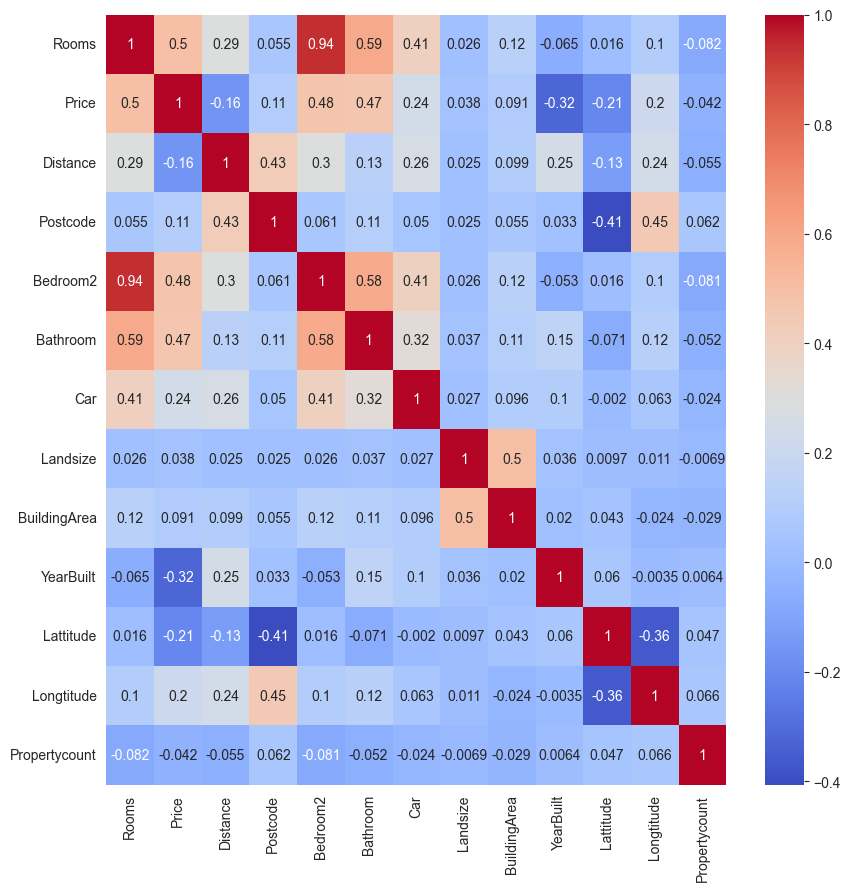

In [73]:
# I have the constraint of picking just two features. Let's pick the ones that have the highest correlation with price.
plt.figure(figsize = (10, 10))
sns.heatmap(unaltered_dataframe.select_dtypes(include=[np.number]).corr(), annot = True, cmap = "coolwarm")

## Step 0: The Super Naive Prediction
Let's start by using the unaltered data and creating a model.

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [75]:
# Handle missing data by removing it.
naive_df = unaltered_dataframe.dropna()
print(len(naive_df))

X = naive_df[['Rooms', 'Bedroom2']]
y = naive_df["Price"]

6196


In [76]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

In [77]:
linear_model = LinearRegression()

In [78]:
linear_model.fit(train_X, train_y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [79]:
price_predictions = linear_model.predict(val_X)

In [93]:
mean_absolute_percentage_error(val_y, price_predictions)

0.39956641126694986

In [80]:
mse = mean_squared_error(val_y, price_predictions)
math.sqrt(mse)

588912.2524997818

<Axes: xlabel='Bedroom2', ylabel='Price'>

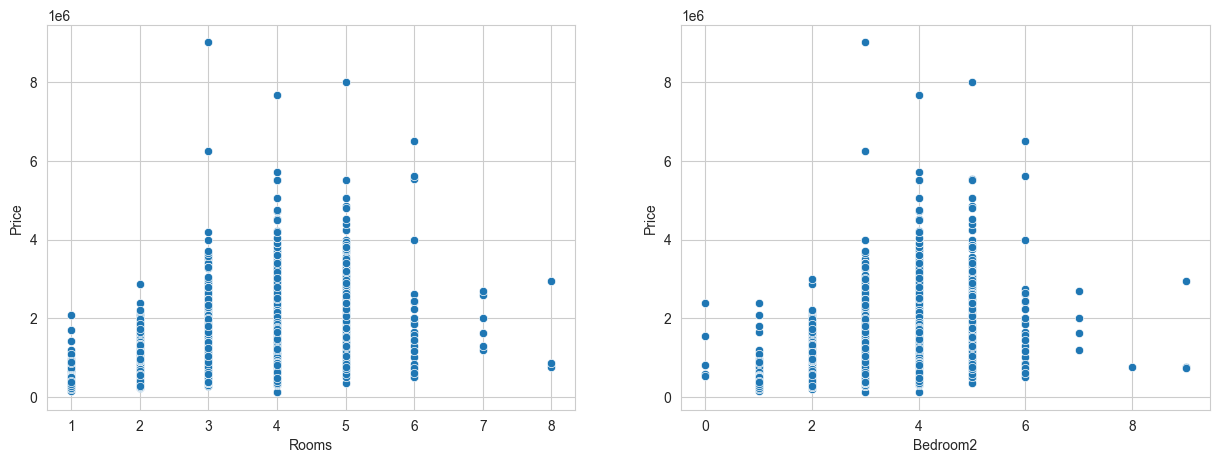

In [81]:
# Let's plot both our variables with price

fig, axes = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = "Rooms", y = "Price", data = naive_df, ax = axes[0])
sns.scatterplot(naive_df, x = "Bedroom2", y = "Price", ax = axes[1])

These two variables basically look the same. Are they each telling my model something new?

In [82]:
print(linear_model.coef_)
print(linear_model.intercept_)
print(list(zip(linear_model.coef_, X.columns)))

[299378.11854822  71225.178398  ]
-14986.069924160838
[(np.float64(299378.1185482193), 'Rooms'), (np.float64(71225.1783980041), 'Bedroom2')]


<Axes: xlabel='Bedroom2', ylabel='Price'>

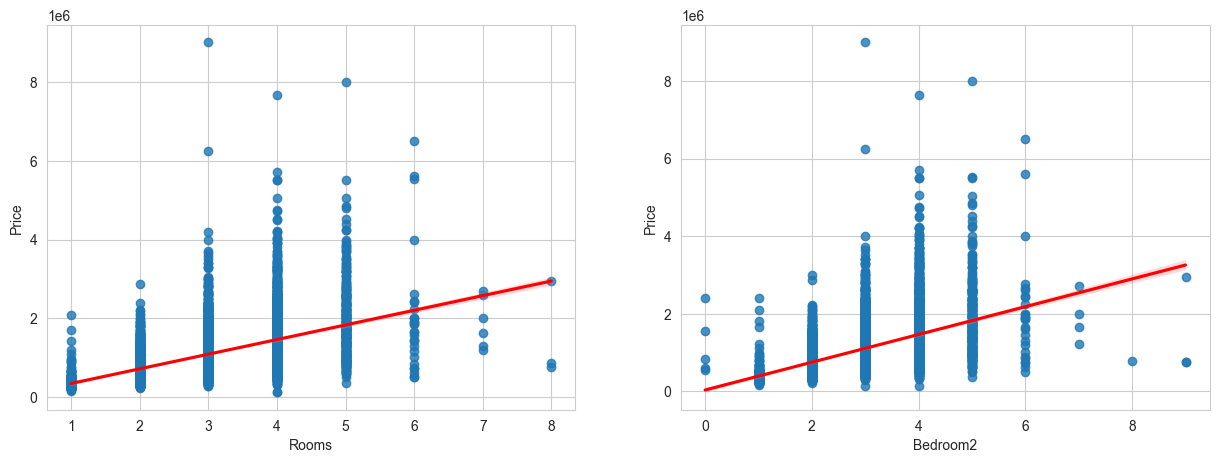

In [83]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
sns.regplot(x="Rooms", y="Price", data=naive_df, ax=axes[0], line_kws={'color':'red'})
sns.regplot(x="Bedroom2", y="Price", data=naive_df, ax=axes[1], line_kws={'color':'red'})

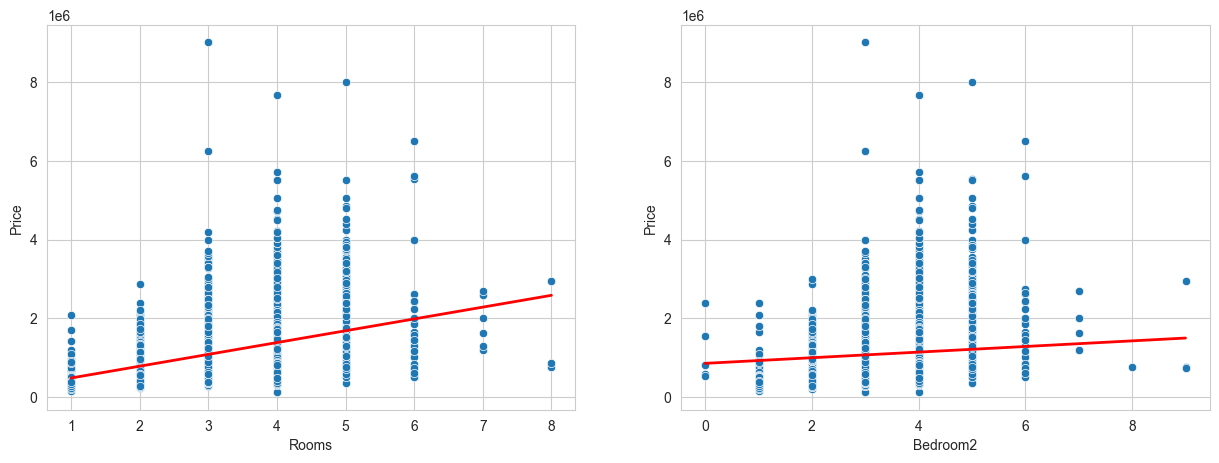

In [84]:
# ... existing code ...
    # Let's plot both our variables with price

fig, axes = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = "Rooms", y = "Price", data = naive_df, ax = axes[0])
sns.scatterplot(x = "Bedroom2", y = "Price", data = naive_df, ax = axes[1])

# To plot a line from a multi-variable model, we have to hold the other variables constant.
# A common practice is to use the mean.
mean_rooms = naive_df['Rooms'].mean()
mean_bedroom2 = naive_df['Bedroom2'].mean()

# The equation is: Price = m1*Rooms + m2*Bedroom2 + c
m1, m2 = linear_model.coef_
c = linear_model.intercept_

# --- Create and plot the line for the 'Rooms' plot ---
# Create a range of values for the x-axis
rooms_x = np.linspace(naive_df['Rooms'].min(), naive_df['Rooms'].max(), 100)
# Calculate the predicted price, holding 'Bedroom2' at its mean
price_y_rooms = m1 * rooms_x + m2 * mean_bedroom2 + c
axes[0].plot(rooms_x, price_y_rooms, color='red', linewidth=2)

# --- Create and plot the line for the 'Bedroom2' plot ---
# Create a range of values for the x-axis
bedroom2_x = np.linspace(naive_df['Bedroom2'].min(), naive_df['Bedroom2'].max(), 100)
# Calculate the predicted price, holding 'Rooms' at its mean
price_y_bedroom2 = m2 * bedroom2_x + m1 * mean_rooms + c
axes[1].plot(bedroom2_x, price_y_bedroom2, color='red', linewidth=2)


<Axes: xlabel='Price', ylabel='Price'>

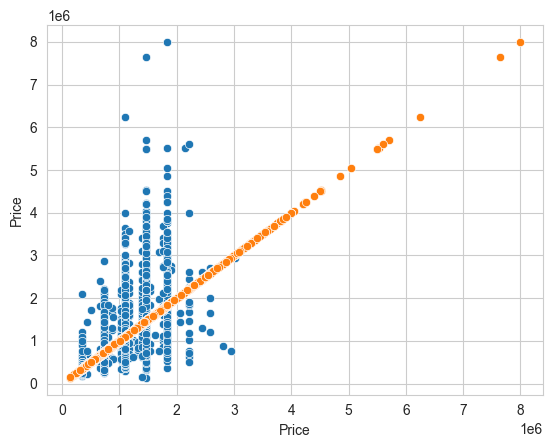

In [90]:
# Visualising the predicted price vs perfect price
pred = linear_model.predict(train_X)
sns.scatterplot(x = pred, y = train_y)
sns.scatterplot(x = train_y, y = train_y)

In [ ]:
sns.scatterplot(x = pred, y = train_y)

What about two other variables?

In [95]:
# Create a list of the pairs of features and loop through with the results
import itertools

In [98]:
lst = [1, 2, 3, 4]
els = [list(x) for x in itertools.combinations(lst, 2)]
els

[[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]

In [101]:
features = unaltered_dataframe.drop("Price", axis=1)

lst = features.columns
els = [list(x) for x in itertools.combinations(lst, 2)]
els

[['Suburb', 'Address'],
 ['Suburb', 'Rooms'],
 ['Suburb', 'Type'],
 ['Suburb', 'Method'],
 ['Suburb', 'SellerG'],
 ['Suburb', 'Date'],
 ['Suburb', 'Distance'],
 ['Suburb', 'Postcode'],
 ['Suburb', 'Bedroom2'],
 ['Suburb', 'Bathroom'],
 ['Suburb', 'Car'],
 ['Suburb', 'Landsize'],
 ['Suburb', 'BuildingArea'],
 ['Suburb', 'YearBuilt'],
 ['Suburb', 'CouncilArea'],
 ['Suburb', 'Lattitude'],
 ['Suburb', 'Longtitude'],
 ['Suburb', 'Regionname'],
 ['Suburb', 'Propertycount'],
 ['Address', 'Rooms'],
 ['Address', 'Type'],
 ['Address', 'Method'],
 ['Address', 'SellerG'],
 ['Address', 'Date'],
 ['Address', 'Distance'],
 ['Address', 'Postcode'],
 ['Address', 'Bedroom2'],
 ['Address', 'Bathroom'],
 ['Address', 'Car'],
 ['Address', 'Landsize'],
 ['Address', 'BuildingArea'],
 ['Address', 'YearBuilt'],
 ['Address', 'CouncilArea'],
 ['Address', 'Lattitude'],
 ['Address', 'Longtitude'],
 ['Address', 'Regionname'],
 ['Address', 'Propertycount'],
 ['Rooms', 'Type'],
 ['Rooms', 'Method'],
 ['Rooms', 'Seller

In [ ]:
# Cross-validate each pair the truly know which pair is best
# Assign Cross validation score for each pair. What about more features.
# GridSearchCV

In [68]:
X = naive_df[['Rooms', 'YearBuilt']]
y = naive_df["Price"]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
linear_model = LinearRegression()
linear_model.fit(train_X, train_y)
price_predictions = linear_model.predict(val_X)
mse = mean_squared_error(val_y, price_predictions)
math.sqrt(mse)

567365.7408440483

The next step is maybe cross-validate?

In [46]:
council_price_df = unaltered_dataframe.copy(deep=True)[['CouncilArea', 'Price']]

In [47]:
council_price_df.CouncilArea.value_counts()
# Moreland, Boroondara are my biggest council areas; is there a significant difference between these areas?

CouncilArea
Moreland             1163
Boroondara           1160
Moonee Valley         997
Darebin               934
Glen Eira             848
Stonnington           719
Maribyrnong           692
Yarra                 647
Port Phillip          628
Banyule               594
Bayside               489
Melbourne             470
Hobsons Bay           434
Brimbank              424
Monash                333
Manningham            311
Whitehorse            304
Kingston              207
Whittlesea            167
Hume                  164
Wyndham                86
Knox                   80
Maroondah              80
Melton                 66
Frankston              53
Greater Dandenong      52
Casey                  38
Nillumbik              36
Yarra Ranges           18
Cardinia                8
Macedon Ranges          7
Unavailable             1
Moorabool               1
Name: count, dtype: int64

In [48]:
stats.ttest_ind(council_price_df.loc[council_price_df.CouncilArea == "Boroondara", "Price"], council_price_df.loc[council_price_df.CouncilArea == "Moreland", "Price"])

TtestResult(statistic=np.float64(28.518636778509592), pvalue=np.float64(1.2714831215007455e-153), df=np.float64(2321.0))

In [49]:
council_price_df.loc[council_price_df.CouncilArea == "Moreland", "Price"].mean()

np.float64(826557.5941530524)

In [50]:
council_price_df.loc[council_price_df.CouncilArea == "Boroondara", "Price"].mean()

np.float64(1647217.3603448276)

In [ ]:
# Post